In [45]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open("./names.txt", 'r').read().splitlines()

In [6]:
words[:4]

['emma', 'olivia', 'ava', 'isabella']

In [13]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [15]:
two_chars = set()
for c1 in chars+["."]:
  for c2 in chars+["."]:
    two_chars.add(c1+c2)

two_chars = sorted(list(two_chars))

stoi2 = {s:i for i,s in enumerate(two_chars)}
itos2 = {i:s for i,s in enumerate(two_chars)}
# stoi2['.e'], itos2[449]

In [16]:
combs = np.arange(300,30001,300)

In [52]:
avg_nll = {}
for comb in combs:
    N = np.zeros((729, 27), dtype=np.float32)
    
    # model smoothing
    N += 1
    
    for w in words[:comb]:
        chs = ["."] + list(w) + ["."]
        for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
            ix1 = stoi2[ch1+ch2]
            ix2 = stoi[ch3]
            N[ix1, ix2] += 1

    P = N
    P /= P.sum(1, keepdims=True)
    n = 0
    log_likelihood = 0.0
    for w in words:
        chs = ["."] + list(w) + ["."]
        for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
            ix1 = stoi2[ch1+ch2]
            ix2 = stoi[ch3]
            prob = P[ix1, ix2]
            logprob = np.log(prob)
            log_likelihood += logprob
            n += 1
    
    nll = -log_likelihood
    # print(f"{nll=}")
    # print(f"{nll/n=}")
    avg_nll[comb] = (nll/n)

KeyboardInterrupt: 

In [47]:
N = np.zeros((729, 27), dtype=np.float32)
    
# model smoothing
N += 2
    
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi2[ch1+ch2]
        ix2 = stoi[ch3]
        N[ix1, ix2] += 1

P = N
P /= P.sum(1, keepdims=True)
P=torch.from_numpy(P)

In [51]:
g = torch.Generator().manual_seed(2147483647)
for _ in range(50):
  ix = 1
  out = ["."]
  while True:
    if ix != 1:
      ix = stoi2[''.join(out[-2:])]
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, generator=g).item()
    out.append(itos[ix])
    if out[-1][-1] == ".":
      break
  
  print(''.join(out))

.luwjdvdianasid.
.ulexay.
.adin.
.vai.
.ritoper.
.maree.
.viameiaurinileniassibduinrwin.
.lessiyanaylarte.
.unviumthyfodtumj.
.nonnslenarsani.
.rose.
.yae.
.rontadaabdinerimouim.
.yffnwanaasnhavikhonszxhddgorfmptpavic.
.le.
.nann.
.rhatin.
.norri.
.ish.
.uyfremmel.
.memalvupwylapphelliarr.
.yen.
.nadortan.
.laylabel.
.hugi.
.lavadoni.
.zhamirayarath.
.bandam.
.lexslettkyzsalee.
.mallen.
.lo.
.fabethellianten.
.naxtmuralodridydznonialiypvrghaitazrwauriabiyah.
.elvavion.
.himah.
.urik.
.mil.
.norinoboin.
.li.
.naiyaxtenn.
.scadwfdadric.
.remyleessianner.
.sadoman.
.kyroderihanazzqdab.
.vidon.
.basstertte.
.zeus.
.dasialejtchlyndfrewelippgklealilondral.
.fadmxjv.
.mishamadvdiyavogairardiyaivion.


Text(0.5, 1.0, 'Decreasing NLL with increasing dataset size')

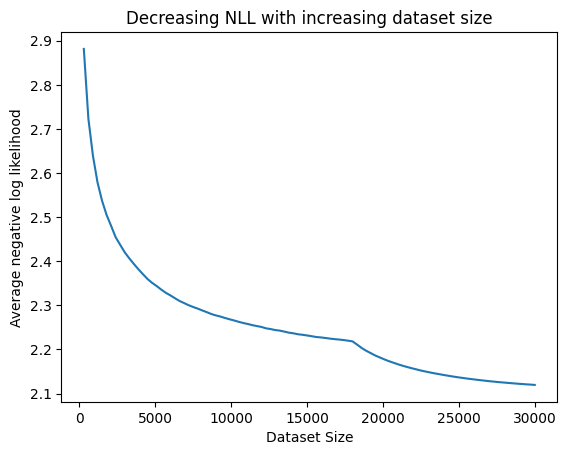

In [40]:
#Plotting the loss function in matplotlib
plt.plot(avg_nll.keys(), avg_nll.values())
plt.xlabel("Dataset Size")
plt.ylabel("Average negative log likelihood")
plt.title("Decreasing NLL with increasing dataset size")